# Use GARCH(1,1) Model to predict next day volatility and use it as a signal for the tail protection strategy

Combine the realized volatility signal from the VEQTOR index and the GARCH forecasted volatility signal.

Test the strategy on S&P 500 and then use it also on other world equity indexes, using the simulated Volatility futures indexes as the instrument to combine with the equity index.


Signal construction:
- Analyze equity index returns and choose the more **adequate GARCH(1,1) specification**.
- **Fit the GARCH model** and obtain **1-day-ahead forecasts** for variance (and hence volatility).
- Find an **adequate volatilty threshold** to use as shock signal: use only the GARCH training data (to avoid hindshigth problems) and find a volatility level which is the 90-th and the 95-th percentile in the 10-days rolling volatility distribution. Use it as fixed signal or **make it rolling (2 years)** so the signal slightly changes over time given new returns data and the market environment evolution.
- Use the GARCH signal to create the tail protection index.

In [1]:
import pandas as pd 
import pandas.util.testing as tm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np 
import seaborn as sns
import math 
import arch as ac
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import ttest_1samp, jarque_bera, shapiro, skew, kurtosis
sns.set()

from functions_thesis import *

ipykernel_launcher:2: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [2]:
# Import data and get log returns
strategies_daily = pd.read_excel("Data_tesi.xlsx", sheet_name="Daily against tail risk", index_col="Dates")
strategies_daily_ret = np.log(1+strategies_daily.pct_change())
strat_daily = strategies_daily[["SPXT", "PPUT", "CLL", "CLLZ", "VXTH", "SPVQDTR", "LOVOL"]]
strat_daily = strat_daily.dropna()
strat_daily_ret = np.log(1+strat_daily.pct_change()).dropna()

#strat_ret["SPY"].loc["2010-01-31":]

ind = pd.read_excel("Data_tesi.xlsx", sheet_name="Daily All ", index_col="Dates")
equity = ind[["SPXT", "UKX", "DAX", "SHCOMP", "NKY", "SP500"]]
equity_ret = np.log(1+equity.pct_change())

vix_index = strategies_daily["VIX"]
vix_index = vix_index.dropna()
vix_index_ret = np.log(1+vix_index.pct_change()).dropna()

strategies = pd.read_excel("Data_tesi.xlsx", sheet_name="Monthly against tail risk", index_col="Dates")
strat = strategies[["SPXT", "PPUT", "CLL", "CLLZ", "VXTH", "SPVQDTR", "LOVOL"]]
strat = strat.dropna()
strat_ret = np.log(1+strat.pct_change()).dropna()

### Example for S&P 500

In [3]:
################ Preliminary S&P 500 analysis #################
# Select the SP only from 2000 as the data we already have when we fit the model
sp = equity_ret["SPXT"].loc["1995-01-01":]
sp_train = sp.loc["1995-01-01":"2006-01-01"]

print(sp_train.describe())
ttest_1samp(sp_train, popmean=0) 

count    2870.000000
mean        0.000414
std         0.010916
min        -0.071122
25%        -0.005237
50%         0.000294
75%         0.006075
max         0.055754
Name: SPXT, dtype: float64


Ttest_1sampResult(statistic=2.0309443555294315, pvalue=0.04235266917605225)

Jarque_beraResult(statistic=1520.4890973969666, pvalue=0.0)
ShapiroResult(statistic=0.9608700275421143, pvalue=3.605873182929534e-27)
Skeweness:  -0.11191142294456594
Excess Kurtosis:  3.558763091365031


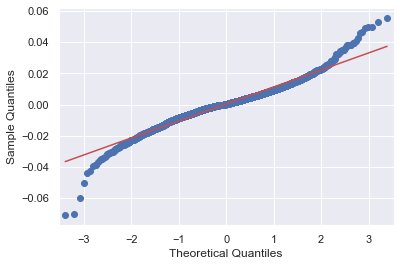

In [4]:
# Normality test
print(jarque_bera(sp_train))
print(shapiro(sp_train))
print("Skeweness: ", skew(sp_train))
print("Excess Kurtosis: ",kurtosis(sp_train))  #excess 

qqplot(sp_train, line="s");

DW test statistic:  2.029747490289565


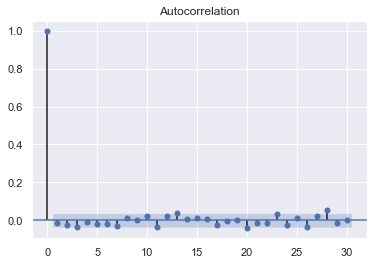

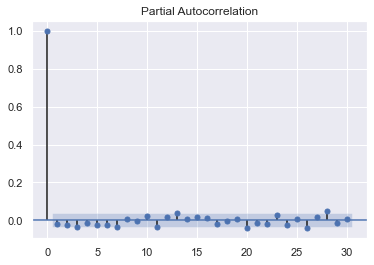

In [5]:
# Autocorrelation analysis

print("DW test statistic: ", durbin_watson(sp_train))  # Within range 1.5 - 2.5, no evidence of autocorrelation because value 2 implies no autocorrelation

plot_acf(sp_train, lags=30)
plot_pacf(sp_train, lags=30);

The data are not normally distributed as expected.

It seems that the mean is very close to zero but the t-test says that it is significantly different from zero for a 5% confidence level. 

There are no clear signs of autocorrelation in the returns and the durbin watson test confirms this hypothesis.

### I will use a process for the returns with constant mean, no autoregressive component and t-Student errors.

In [6]:
################ Fit a simple GARCH(1,1) to S&P 500 log returns data #################
split_date = "2006-01-01"

garchmodel = ac.univariate.arch_model(y=sp*100,  #model require to scale *100
                                mean="Constant",  #AR(1) for returns using "AR" and lags=)
                                vol="GARCH",      #the volatility model required
                                p=1, o=0, q=1,    #garch parameters
                                dist="studentst") #t-student errors
modelfit = garchmodel.fit(last_obs=split_date, disp="off")
modelfit.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         SPXT   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3907.37
Distribution:      Standardized Student's t   AIC:                           7824.74
Method:                  Maximum Likelihood   BIC:                           7854.55
                                              No. Observations:                 2870
Date:                      Mon, May 03 2021   Df Residuals:                     2869
Time:                              22:02:53   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0767  1.464e-02      5.237  1.634e-07 [4.796e-02,  0.105]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      5.6738e-03  2.511e-03      2.260  2.383e-02 [7.531e-04,1.059e-02]
alpha[1]       0.0586  1.212e-02      4.840  1.299e-06 [3.489e-02,8.239e-02]
beta[1]        0.9384  1.229e-02     76.348      0.000     [  0.914,  0.962]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             7.6250      1.174      6.497  8.185e-11 [  5.325,  9.925]
========================================================================

Covariance estimator: robust
"""

In [7]:
print(modelfit.params["omega"])
print(modelfit.params["alpha[1]"])
print(modelfit.params["beta[1]"])

0.005673786555796017
0.05864298782166701
0.9383530723558815


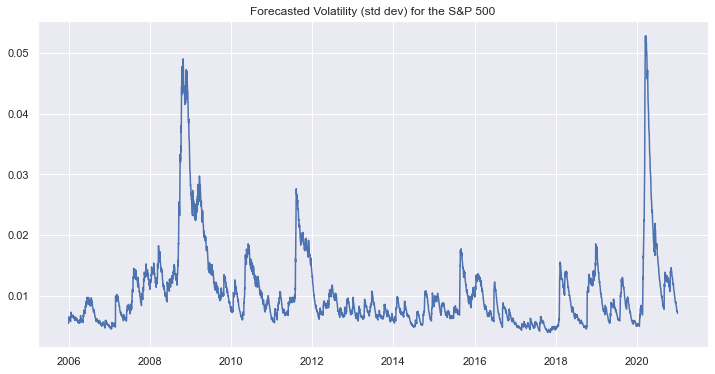

In [8]:
########### Make predictions with the GARCH Model ###################
# Analytical
forecasts = modelfit.forecast(horizon=1, start=split_date)
var_forecasts = forecasts.variance[split_date:]
# Volatility forecasts without *100 scale
std_forecasts = np.sqrt(var_forecasts)/100

plt.figure(figsize=(12, 6))
plt.plot(std_forecasts,  label="Analytical")
plt.title("Forecasted Volatility (std dev) for the S&P 500");

In [9]:
print(float(std_forecasts.mean()))
print(float(std_forecasts.std()))

0.010562875752537617
0.006921022880529942


In [10]:
# Compare with the forecasts
sp_oos = sp.loc["2006-01-01":]
print("Daily Volatility for OOS data:                 ", sp_oos.std())
print("Average rolling 10 days daily volatility OOS:  ", np.mean(sp_oos.rolling(10).std()))

Daily Volatility for OOS data:                  0.012566317825702429
Average rolling 10 days daily volatility OOS:   0.009855090863667452


In [11]:
# Choose thresholds for the signals
# The objective is to select a volatility level to create two garch signals, to indicate when the volatility level is in the 90-th and in the 95-th percentile

# Data used as training data, not used to compute the index
sp_train_vol = sp_train.rolling(10).std()
print("Average rolling 10 days daily volatility: ", sp_train_vol.mean())

# I changed the threshold manually to obtain a 10% and 5% result
pct10 = sum(1 for i in sp_train_vol if i > 0.016)   #count the number of times the condition is satisfied
pct5 = sum(1 for i in sp_train_vol if i > 0.0195)
print("% of 10-days windows above the level: ", int(pct10/len(sp_train_vol)*100), "%")
print("% of 10-days windows above the level: ", int(pct5/len(sp_train_vol)*100), "%")

Average rolling 10 days daily volatility:  0.009822414680877141
% of 10-days windows above the level:  10 %
% of 10-days windows above the level:  4 %


In [12]:
# Use the percentiles
a = np.nanpercentile(sp_train_vol, 90).round(4)
a

0.016

In [13]:
b = np.nanpercentile(sp_train_vol, 95).round(4)
b

0.0194

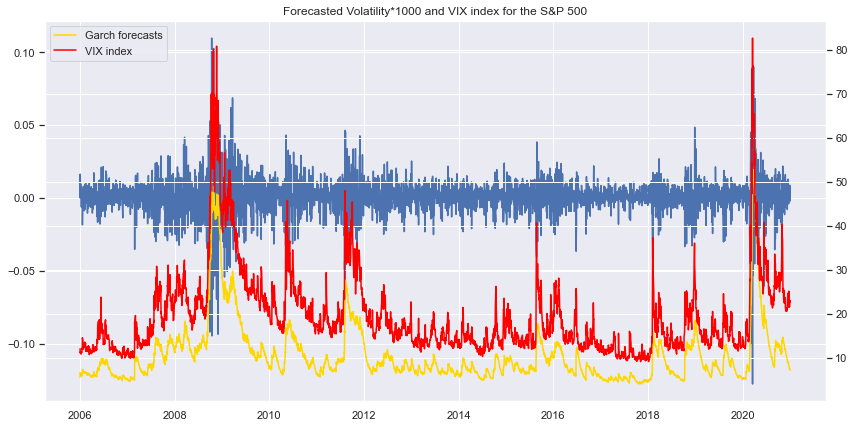

In [14]:
vix = vix_index.loc[split_date:]

fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.plot(sp_oos)
ax2 = ax1.twinx()
#obtain same scale
ax2.plot(std_forecasts*1000,  "gold", label="Garch forecasts")
ax2.plot(vix,  "red", label="VIX index")
ax2.legend()
plt.title("Forecasted Volatility*1000 and VIX index for the S&P 500");

In [15]:
# Analysis of GARCH results --> they're in line with signal choosen
val = np.array(std_forecasts.values)
pct10 = sum(1 for i in val if i > 0.016)
pct5 = sum(1 for i in val if i > 0.0194)
print("% of GARCH forecasts above the level: ", int(pct10/len(val)*100), "%")
print("% of GARCH forecasts above the level: ", int(pct5/len(val)*100), "%")

% of GARCH forecasts above the level:  11 %
% of GARCH forecasts above the level:  7 %


### Application for all indexes

In [16]:
pd.options.mode.chained_assignment = None
def garch_specification_training(tot_retdata, beg_date, split_date): 
    """
    Define the optimal GARCH(1,1) specification given return data and fit the model.
    INPUTS:
    - 
    OUTPUT: dataframe with forecasted volatility, 10% and 5% signals from training data.
    """

    train_data = tot_retdata.loc[beg_date:split_date]

    ###### Set mean and underlying distribution of the GARCH model ######
    mean_garch = None
    dist_garch = "Normal"
    # Test the mean
    pval = ttest_1samp(sp_train, popmean=0)[1]  # if p-value > 0.05 the mean is != 0
    # Test Autocorrelation
    dw = durbin_watson(sp_train)
    if pval < 0.05 and dw > 1.7 and dw < 2.3:
        mean_garch = "AR"
    elif pval < 0.05 and dw < 1.7 or dw > 2.3:
        mean_garch = "Constant"
    elif pval > 0.05:
        mean_garch = "Zero"
    # Test normality
    norm = jarque_bera(sp_train)[1]
    if norm < 0.05:
        dist_garch = "studentst"
    
    ###### Fit the Model ######
    garchmodel = ac.univariate.arch_model(y=tot_retdata*100,  #model require to scale *100
                                        mean=mean_garch, vol="GARCH", p=1, o=0, q=1,
                                        dist=dist_garch) 
    modelfit = garchmodel.fit(last_obs=split_date, disp="off")

    ###### Forecast volatility ######
    forecasts = modelfit.forecast(horizon=1, start=split_date)
    var_forecasts = forecasts.variance[split_date:]
    std_forecasts = np.sqrt(var_forecasts)/100    # Volatility forecasts without *100 scale

    ###### Obtain the signal thresholds from the training data ######
    train_vol = train_data.rolling(10).std()
    sig10pct = np.nanpercentile(train_vol, 90).round(4)
    sig5pct = np.nanpercentile(train_vol, 95).round(4)

    return std_forecasts, sig10pct, sig5pct


def data_for_strategy_garch(dataframe, ticker, garch_forecast, sig10, sig5, fut_index):
    """
    INPUTS:
    - dataframe = dataframe with DAILY PRICES of equity index
    - ticker = equity index ticker
    - garch_forecast = forecasted variance from arch library
    ......
    """
    #Create the dataframe with the data needed (dates are in line)
    spindex = pd.DataFrame(dataframe[ticker])                           # equity index
    x = spindex.merge(strategies_daily[fut_index], on="Dates").dropna() # add VIX futures
    x = x.merge(garch_forecast, on="Dates").dropna()                    # add forecasts
    x.rename(columns={fut_index: "VIX_FUT"}, inplace=True)
    x.rename(columns={"h.1": "garch"}, inplace=True)

    # Realized Volatility
    x["Ret_VIX_FUT"] = np.log(1+x["VIX_FUT"].pct_change())
    x["Ret_{}".format(ticker)] = np.log(1+x[ticker].pct_change())
    x["Realized_vol"] = np.sqrt((252*(x["Ret_{}".format(ticker)]**2).rolling(22).sum())/22)

    # Create GARCH signal
    x["garch10%"] = np.where(x["garch"] > sig10, 1, -1)
    x["garch5%"] = np.where(x["garch"] > sig5, 1, -1)
    x = x.dropna()
    return x

In [17]:
### FUNCTION THAT CREATES THE SIGNALS, WITH A ROLLING SIGNAL FOR THE TARGETED GARCH VOLATILITY

def data_for_strategy_garch_changingsignal(dataframe, ticker, garch_forecast, sig10, sig5, fut_index, longer_period=True):

    #Create the dataframe with the data needed
    spindex = pd.DataFrame(dataframe[ticker])                     
    #x = spindex.merge(strategies_daily["VIX"], on="Dates")  # add VIX
    x = spindex.merge(strategies_daily[fut_index], on="Dates").dropna() # add VIX futures
    x = x.merge(garch_forecast, on="Dates").dropna() # add VIX futures
    x.rename(columns={fut_index: "VIX_FUT"}, inplace=True)
    x.rename(columns={"h.1": "garch"}, inplace=True)

    # Realized Volatility
    x["Ret_VIX_FUT"] = np.log(1+x["VIX_FUT"].pct_change())
    x["Ret_{}".format(ticker)] = np.log(1+x[ticker].pct_change())
    x["Realized_vol"] = np.sqrt((252*(x["Ret_{}".format(ticker)]**2).rolling(22).sum())/22)
    x["garch10%"] = np.zeros(len(x))
    x["garch5%"] = np.zeros(len(x))
    # Create GARCH signal
    if longer_period == True:
        for i in range(4, 15):  
            if i < 14:
                # First 3 years keep the same
                x["garch10%"].iloc[0:252*3] = np.where(x["garch"].iloc[0:252*3] > sig10, 1, -1)
                x["garch5%"].iloc[0:252*3] = np.where(x["garch"].iloc[0:252*3] > sig5, 1, -1)

                # Now rebalance the signal
                train_vol = x["Ret_{}".format(ticker)].iloc[252*(i-3):252*(i-1)].rolling(10).std()
                sig10pct = np.nanpercentile(train_vol, 90).round(4)
                sig5pct = np.nanpercentile(train_vol, 95).round(4)
                x["garch10%"].iloc[252*(i-1):252*i] = np.where(x["garch"].iloc[252*(i-1):252*i] > sig10pct, 1, -1)
                x["garch5%"].iloc[252*(i-1):252*i] = np.where(x["garch"].iloc[252*(i-1):252*i] > sig5pct, 1, -1)
            else:
                train_vol = x["Ret_{}".format(ticker)].iloc[252*(i-3):252*(i-1)].rolling(10).std()
                sig10pct = np.nanpercentile(train_vol, 90).round(4)
                sig5pct = np.nanpercentile(train_vol, 95).round(4)
                x["garch10%"].iloc[252*(i-1):] = np.where(x["garch"].iloc[252*(i-1):] > sig10pct, 1, -1)
                x["garch5%"].iloc[252*(i-1):] = np.where(x["garch"].iloc[252*(i-1):] > sig5pct, 1, -1)
    else:
        for i in range(4, 10):   #from 4 to 14 for OTHER (more data) (4,15)
            if i < 9:
                # First 3 years keep the same
                x["garch10%"].iloc[0:252*3] = np.where(x["garch"].iloc[0:252*3] > sig10, 1, -1)
                x["garch5%"].iloc[0:252*3] = np.where(x["garch"].iloc[0:252*3] > sig5, 1, -1)

                # Now rebalance the signal
                train_vol = x["Ret_{}".format(ticker)].iloc[252*(i-3):252*(i-1)].rolling(10).std()
                sig10pct = np.nanpercentile(train_vol, 90).round(4)
                sig5pct = np.nanpercentile(train_vol, 95).round(4)
                x["garch10%"].iloc[252*(i-1):252*i] = np.where(x["garch"].iloc[252*(i-1):252*i] > sig10pct, 1, -1)
                x["garch5%"].iloc[252*(i-1):252*i] = np.where(x["garch"].iloc[252*(i-1):252*i] > sig5pct, 1, -1)
            else:
                train_vol = x["Ret_{}".format(ticker)].iloc[252*(i-3):252*(i-1)].rolling(10).std()
                sig10pct = np.nanpercentile(train_vol, 90).round(4)
                sig5pct = np.nanpercentile(train_vol, 95).round(4)
                x["garch10%"].iloc[252*(i-1):] = np.where(x["garch"].iloc[252*(i-1):] > sig10pct, 1, -1)
                x["garch5%"].iloc[252*(i-1):] = np.where(x["garch"].iloc[252*(i-1):] > sig5pct, 1, -1)

    x = x.dropna()
    return x

In [18]:
def create_index_garch(dataframe, ticker, data_garch, beg_date, split_date, fut_index, w1, w2, w3, w4, w5, basic=True, longer_period=True):
    """
    Strategy with relaized volatility signal and GARCH signal.
    """
    garch_forecast, sig10, sig5 = garch_specification_training(tot_retdata=data_garch, beg_date=beg_date, split_date=split_date)

    if basic == True:
        df = data_for_strategy_garch(dataframe=dataframe, ticker=ticker, garch_forecast=garch_forecast, sig10=sig10, sig5=sig5, fut_index=fut_index)
    else:
        df = data_for_strategy_garch_changingsignal(dataframe=dataframe, ticker=ticker, garch_forecast=garch_forecast, sig10=sig10, sig5=sig5, fut_index=fut_index, longer_period=longer_period)

    sp = df["Ret_{}".format(ticker)].values
    fut = df["Ret_VIX_FUT"].values
    index = []
    wSP = []
    wFUT = []
    wSP.append(0)
    wFUT.append(0)
    index.append(0) # first zero to have same lenght as df
    for i in range(len(df)-1):  #not for the last because we don't have data for next day
        if (df["Realized_vol"].iloc[i] < 0.1) == True:
            if (df["garch5%"].iloc[i+1] ==1) == True:  # Above 0.2
                index.append(sp[i+1]*w3 + fut[i+1]*(1-w3))
                wSP.append(w3)
                wFUT.append((1-w3))     
            else:
                index.append(sp[i+1]*w5 + fut[i+1]*(1-w5))
                wSP.append(w5)
                wFUT.append((1-w5)) 
        elif ((df["Realized_vol"].iloc[i] >= 0.1) == True) and ((df["Realized_vol"].iloc[i] < 0.2) == True):
            if (df["garch5%"].iloc[i+1] ==1) == True:  # Above 0.2
                index.append(sp[i+1]*w3 + fut[i+1]*(1-w3))
                wSP.append(w3)
                wFUT.append((1-w3))     
            else: 
                index.append(sp[i+1]*w5 + fut[i+1]*(1-w5)) 
                wSP.append(w5)
                wFUT.append((1-w5))
        elif ((df["Realized_vol"].iloc[i] >= 0.2) == True) and ((df["Realized_vol"].iloc[i] < 0.35) == True):
            if (df["garch5%"].iloc[i+1] ==1) == True:  # Above 0.2
                index.append(sp[i+1]*w2 + fut[i+1]*(1-w2))  
                wSP.append(w2)
                wFUT.append((1-w2)) 
            elif ((df["garch10%"].iloc[i+1] == 1) == True) and ((df["garch5%"].iloc[i+1] ==1) == False): # Between 0.15 and 0.2
                index.append(sp[i+1]*w4 + fut[i+1]*(1-w4))
                wSP.append(w4)
                wFUT.append((1-w4))  
            else: # Below 0.15
                index.append(sp[i+1]*w5 + fut[i+1]*(1-w5))
                wSP.append(w5)
                wFUT.append((1-w5)) 
        elif ((df["Realized_vol"].iloc[i] >= 0.35) == True) and ((df["Realized_vol"].iloc[i] < 0.45) == True):
            if (df["garch5%"].iloc[i+1] ==1) == True:  # Above 0.2
                index.append(sp[i+1]*w1 + fut[i+1]*(1-w1))
                wSP.append(w1)
                wFUT.append((1-w1))   
            elif ((df["garch10%"].iloc[i+1] == 1) == True) and ((df["garch5%"].iloc[i+1] ==1) == False): # Between 0.15 and 0.2
                index.append(sp[i+1]*w2 + fut[i+1]*(1-w2))
                wSP.append(w2)
                wFUT.append((1-w2))  
            else: # Below 0.15
                index.append(sp[i+1]*w3 + fut[i+1]*(1-w3))
                wSP.append(w3)
                wFUT.append((1-w3))    
        else:
            if (df["garch5%"].iloc[i+1] ==1) == True:  # Above 0.2
                index.append(sp[i+1]*w1 + fut[i+1]*(1-w1))
                wSP.append(w1)
                wFUT.append((1-w1))    
            elif ((df["garch10%"].iloc[i+1] == 1) == True) and ((df["garch5%"].iloc[i+1] ==1) == False): # Between 0.15 and 0.2
                index.append(sp[i+1]*w1 + fut[i+1]*(1-w1))
                wSP.append(w1)
                wFUT.append((1-w1))   
            else: # Below 0.15
                index.append(sp[i+1]*w2 + fut[i+1]*(1-w2))
                wSP.append(w2)
                wFUT.append((1-w2))

    df["Ret_INDEX"] = index
    return df, wSP, wFUT

In [19]:
def index_ONLYGARCH(dataframe, ticker, data_garch, beg_date, split_date, fut_index, w1, w2, w3, basic=True, longer_period=True):
    """
    Strategy using only GARCH
    """
    garch_forecast, sig10, sig5 = garch_specification_training(tot_retdata=data_garch, beg_date=beg_date, split_date=split_date)

    if basic == True:
        df = data_for_strategy_garch(dataframe=dataframe, ticker=ticker, garch_forecast=garch_forecast, sig10=sig10, sig5=sig5, fut_index=fut_index)
    else:
        df = data_for_strategy_garch_changingsignal(dataframe=dataframe, ticker=ticker, garch_forecast=garch_forecast, sig10=sig10, sig5=sig5, fut_index=fut_index, longer_period=longer_period)
    
    sp = df["Ret_{}".format(ticker)].values
    fut = df["Ret_VIX_FUT"].values
    index = []
    index.append(0)
    for i in range(len(df)-1):  #not for the last because we don't have data for next day
        if (df["garch5%"].iloc[i+1] ==1) == True:  
            index.append(sp[i+1]*w1 + fut[i+1]*(1-w1)) 
        elif ((df["garch10%"].iloc[i+1] == 1) == True) and ((df["garch5%"].iloc[i+1] ==1) == False):
            index.append(sp[i+1]*w2 + fut[i+1]*(1-w2))
        else:
            index.append(sp[i+1]*w3 + fut[i+1]*(1-w3))
    
    df["Ret_INDEX"] = index
    return df

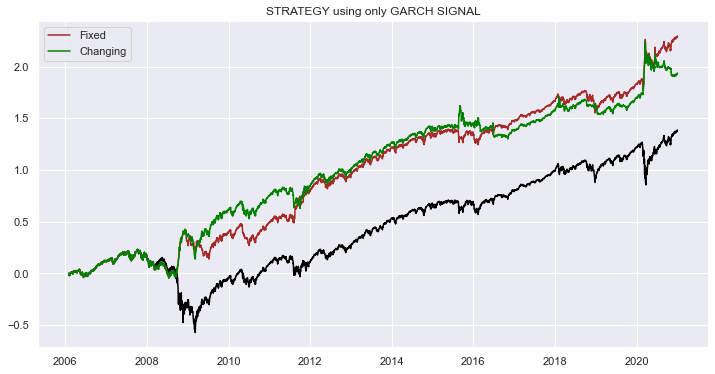

In [20]:
######################## Strategy using only GARCH ########################
ONLYGARCH = index_ONLYGARCH(equity, "SPXT", sp, "1995-01-01", "2006-01-01", "SPVXSTR", 0.5, 0.8, 1)
ONLYGARCH_ROLL = index_ONLYGARCH(equity, "SPXT", sp, "1995-01-01", "2006-01-01", "SPVXSTR", 0.5, 0.8, 1, basic=False)

plt.figure(figsize=(12, 6))
plt.plot(ONLYGARCH["Ret_SPXT"].cumsum(), "black")
plt.plot(ONLYGARCH["Ret_INDEX"].cumsum(), "brown", label="Fixed")
plt.plot(ONLYGARCH_ROLL["Ret_INDEX"].cumsum(), "green", label="Changing")
plt.title("STRATEGY using only GARCH SIGNAL")
plt.legend();

In [21]:
######################### COMPLETE STRATEGY ########################
garch_spxt = create_index_garch(equity, "SPXT", sp, "1995-01-01", "2006-01-01", "SPVXSTR", 0.5, 0.75, 0.85, 0.95, 1)[0]
#garch_spxt.to_excel("MyGARCH.xlsx")

# Strategy with same weights as original VEQTOR
garch_spxt_VEQTOR = create_index_garch(equity, "SPXT", sp, "1995-01-01", "2006-01-01", "SPVXSTR", 0.6, 0.75, 0.85, 0.90, 0.975)[0]

# Changing signal 
garch_spxt_changing = create_index_garch(equity, "SPXT", sp, "1995-01-01", "2006-01-01", "SPVXSTR", 0.5, 0.75, 0.85, 0.95, 1, basic=False)[0]

In [22]:
# Get the allocation weights
wsp, wfut = create_index_garch(equity, "SPXT", sp, "1995-01-01", "2006-01-01", "SPVXSTR",0.5, 0.75, 0.85, 0.95, 1)[1:3]
wsp = np.array(wsp)
wfut = np.array(wfut)

weights_data = pd.DataFrame({"SP_weights": wsp, "VIXFut_weights": wfut, "Tot": (wsp+wfut)}, index=garch_spxt.index)

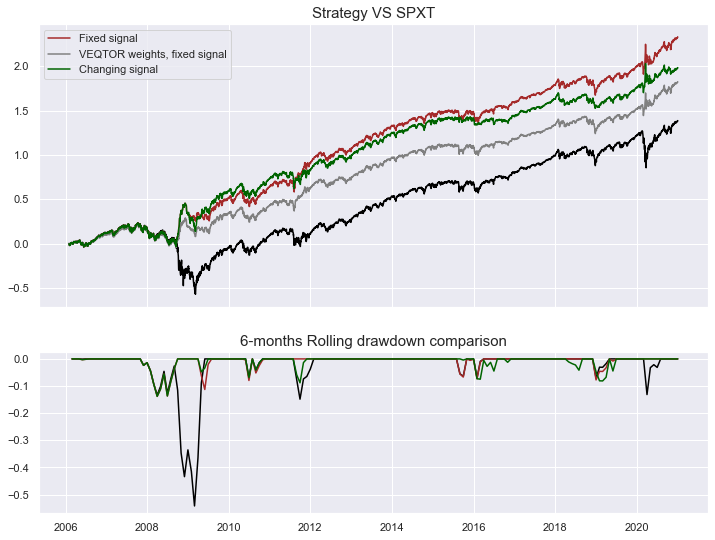

In [23]:
# Resample and plot to compare with actual VEQTOR
mh = garch_spxt[["Ret_SPXT", "Ret_INDEX"]].resample("M").sum()
ga_veq = garch_spxt_VEQTOR[["Ret_SPXT", "Ret_INDEX"]].resample("M").sum()
mhh = garch_spxt_changing[["Ret_SPXT", "Ret_INDEX"]].resample("M").sum()
mh.rename(columns={"Ret_INDEX": "Ret_GARCH_INDEX"}, inplace=True)
ga_veq.rename(columns={"Ret_INDEX": "Ret_GARCH_INDEX"}, inplace=True)
mhh.rename(columns={"Ret_INDEX": "Ret_GARCH_INDEX"}, inplace=True)

# Rollinf drawdown of the GRACH strategy
drd = drawdown(mh)
drdd = drawdown(mhh)

# Daily data
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(garch_spxt["Ret_SPXT"].cumsum(), "black")
ax[0].plot(garch_spxt["Ret_INDEX"].cumsum(), "brown", label="Fixed signal")
ax[0].plot(garch_spxt_VEQTOR["Ret_INDEX"].cumsum(), "grey", label="VEQTOR weights, fixed signal")
ax[0].plot(garch_spxt_changing["Ret_INDEX"].cumsum(), "darkgreen", label="Changing signal")
ax[0].legend()
#plt.plot(strat_daily_ret["SPVQDTR"].cumsum(), "green", linestyle="--");
ax[0].set_title("Strategy VS SPXT", fontsize=15)
ax[1].plot(drd["Ret_SPXT"], "black")
ax[1].plot(drd["Ret_GARCH_INDEX"], "brown")
ax[1].plot(drdd["Ret_GARCH_INDEX"], "darkgreen")
ax[1].set_title("6-months Rolling drawdown comparison", fontsize=15);

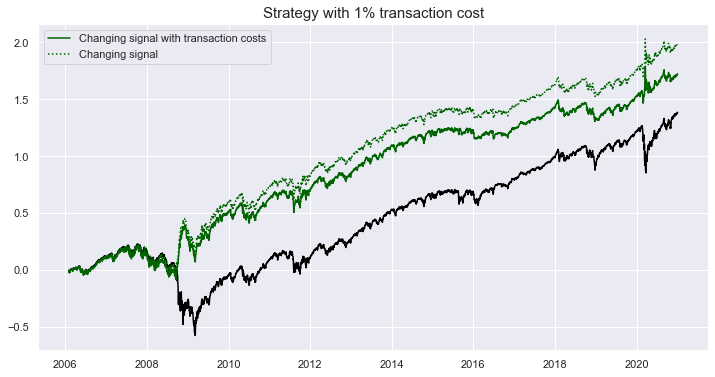

In [24]:
########### TRANSACTION COSTS ###########
test = garch_spxt_changing["Ret_INDEX"].copy()
test[test > 0.0] = test*0.99
test[test < 0.0] = test*1.01

plt.figure(figsize=(12, 6))
plt.plot(garch_spxt_changing["Ret_SPXT"].cumsum(), "black")
plt.plot(test.cumsum(), "darkgreen", label="Changing signal with transaction costs")
plt.plot(garch_spxt_changing["Ret_INDEX"].cumsum(), "darkgreen", linestyle="dotted", label="Changing signal")
plt.title("Strategy with 1% transaction cost", fontsize=15)
plt.legend();

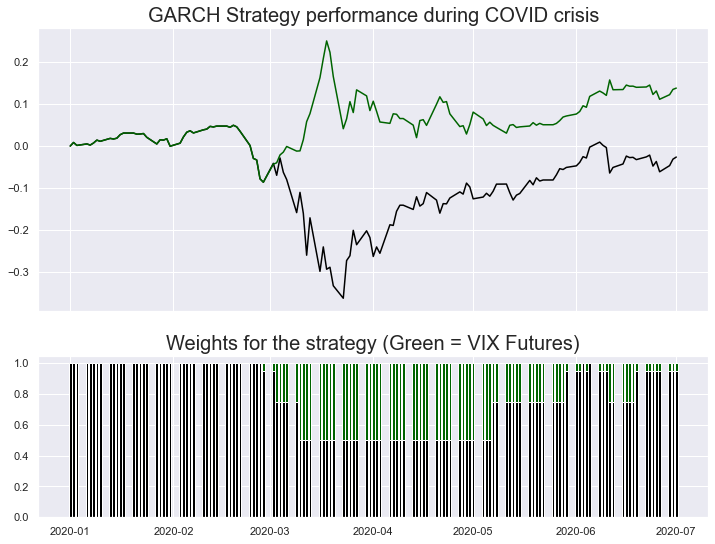

In [25]:
# Strategy in 2020 crisis
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(garch_spxt["Ret_SPXT"].loc["2020-01-01":"2020-07-01"].cumsum(), "black")
ax[0].plot(garch_spxt["Ret_INDEX"].loc["2020-01-01":"2020-07-01"].cumsum(), "darkgreen")
ax[0].set_title("GARCH Strategy performance during COVID crisis", fontsize=20)
ax[1].bar(x=weights_data.loc["2020-01-01":"2020-07-01"].index, height=weights_data["Tot"].loc["2020-01-01":"2020-07-01"], color="darkgreen")
ax[1].bar(x=weights_data.loc["2020-01-01":"2020-07-01"].index, height=weights_data["SP_weights"].loc["2020-01-01":"2020-07-01"], color="black")
ax[1].set_title("Weights for the strategy (Green = VIX Futures)", fontsize=20);

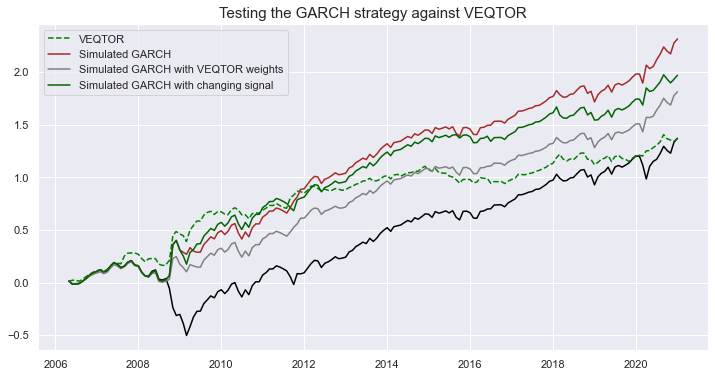

In [26]:
# Monthly comparison with VEQTOR
plt.figure(figsize=(12, 6))
plt.plot(mh["Ret_SPXT"].iloc[2:].cumsum(), "black")
plt.plot(strat_ret["SPVQDTR"].cumsum(), "green",linestyle="--", label="VEQTOR")
plt.plot(mh["Ret_GARCH_INDEX"].iloc[2:].cumsum(), "brown", label="Simulated GARCH")
plt.plot(ga_veq["Ret_GARCH_INDEX"].iloc[2:].cumsum(), "grey", label="Simulated GARCH with VEQTOR weights")
plt.plot(mhh["Ret_GARCH_INDEX"].iloc[2:].cumsum(), "darkgreen", label="Simulated GARCH with changing signal")
plt.title("Testing the GARCH strategy against VEQTOR", fontsize=15)
plt.legend();

In [27]:
t1 = traditional_metrics(mh, equity, no_price=True) #equity not used
sp1 = specific_metrics(mh, 0.0, -0.05, -0.1)

# VEQTOR weights
t2 = traditional_metrics(ga_veq, equity, no_price=True)
sp2 = specific_metrics(ga_veq, 0.0, -0.05, -0.1)

# Changing signal
t3 = traditional_metrics(mhh, equity, no_price=True)
sp3 = specific_metrics(mhh, 0.0, -0.05, -0.1)

/Users/AlessioGiust/Desktop/TESI/Codici Tesi/functions_thesis.py:26: RuntimeWarning: invalid value encountered in double_scalars
  IR.append((avg_ret_data[tick] - avg_ret_data[index_tick])/(qq["diff_sp_{}".format(tick)].std()))
/Users/AlessioGiust/Desktop/TESI/Codici Tesi/functions_thesis.py:26: RuntimeWarning: invalid value encountered in double_scalars
  IR.append((avg_ret_data[tick] - avg_ret_data[index_tick])/(qq["diff_sp_{}".format(tick)].std()))
/Users/AlessioGiust/Desktop/TESI/Codici Tesi/functions_thesis.py:26: RuntimeWarning: invalid value encountered in double_scalars
  IR.append((avg_ret_data[tick] - avg_ret_data[index_tick])/(qq["diff_sp_{}".format(tick)].std()))


In [28]:
t1.rename({"Ret_GARCH_INDEX": "Basic GARCH"}, axis=0, inplace=True)
t1.rename({"Ret_SPXT": "SPXT"}, axis=0, inplace=True)
summ_trad = t1.append(t2.iloc[1:, :], ignore_index=False)
summ_trad.rename({"Ret_GARCH_INDEX": "GARCH VEQTOR weigths"}, axis=0,inplace=True)
summ_trad = summ_trad.append(t3.iloc[1:, :], ignore_index=False)
summ_trad.rename({"Ret_GARCH_INDEX": "GARCH changing signal"}, axis=0,inplace=True)
summ_trad

In [29]:
sp1.rename({"Ret_GARCH_INDEX": "Basic GARCH"}, axis=0, inplace=True)
sp1.rename({"Ret_SPXT": "SPXT"}, axis=0, inplace=True)
summ_sp = sp1.append(sp2.iloc[1:, :], ignore_index=False)
summ_sp.rename({"Ret_GARCH_INDEX": "GARCH VEQTOR weigths"}, axis=0,inplace=True)
summ_sp = summ_sp.append(sp3.iloc[1:, :], ignore_index=False)
summ_sp.rename({"Ret_GARCH_INDEX": "GARCH changing signal"}, axis=0,inplace=True)
summ_sp

## Apply to other equity indexes
There are still some problems given that the VIX futures might not ptivide adequate payoffs in certain periods when SP was not suffering as the index used, but with the GARCH the timing is improved because in this case both singals are based on data for the actual index of interest and not on the VIX.

In [30]:
# Try with DAX
dax = equity_ret["DAX"].loc["1995-01-01":]
garch_dax = create_index_garch(equity, "DAX", dax, "1995-01-01", "2006-01-01", "SPVXSTR",0.5, 0.75, 0.85, 0.95, 1)[0]

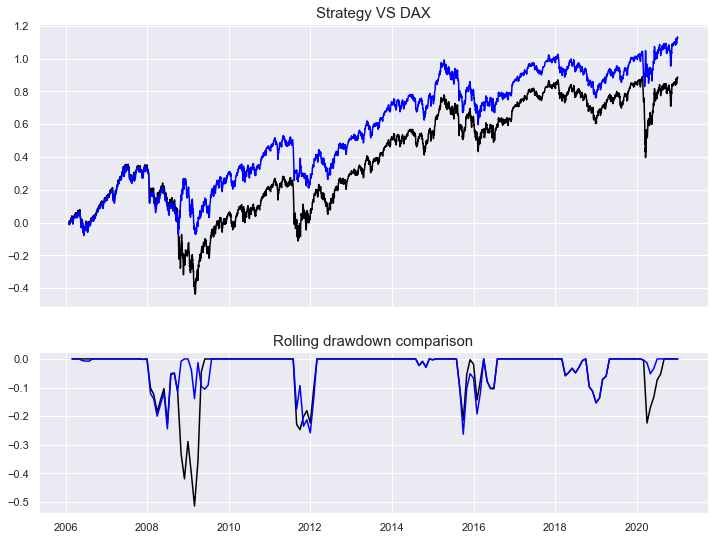

In [31]:
# Resample and plot to compare with actual VEQTOR
datadax = garch_dax[["Ret_DAX", "Ret_INDEX"]].resample("M").sum()
datadax.rename(columns={"Ret_INDEX": "Ret_GARCH_INDEX"}, inplace=True)

# Rolling drawdown of the GRACH strategy
drd = drawdown(datadax)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(garch_dax["Ret_DAX"].cumsum(), "black")
ax[0].plot(garch_dax["Ret_INDEX"].cumsum(), "blue")
ax[0].set_title("Strategy VS DAX", fontsize=15)
ax[1].plot(drd["Ret_DAX"], "black")
ax[1].plot(drd["Ret_GARCH_INDEX"], "blue")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

In [32]:
# Try with NIKKEI
nky = equity_ret["NKY"].loc["1995-01-01":]
garch_NK = create_index_garch(equity, "NKY", nky, "1995-01-01", "2006-01-01", "SPVXSTR",0.5, 0.75, 0.85, 0.95, 1)[0]

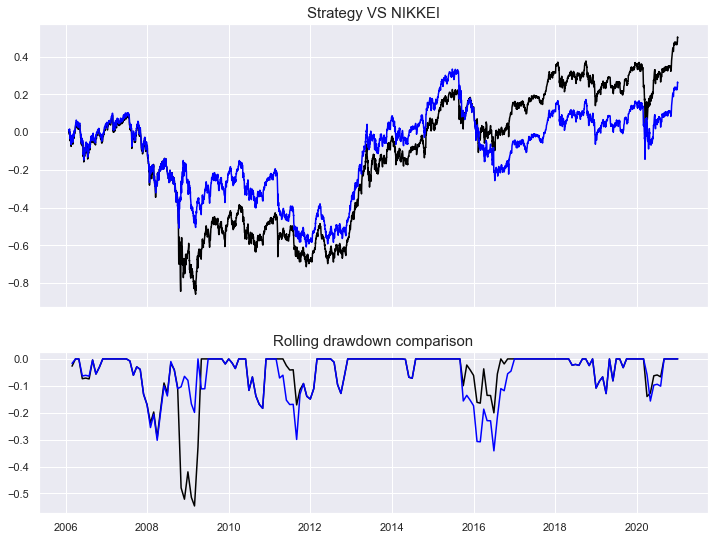

In [33]:
dataNK = garch_NK[["Ret_NKY", "Ret_INDEX"]].resample("M").sum()
dataNK.rename(columns={"Ret_INDEX": "Ret_GARCH_INDEX"}, inplace=True)

# Rolling drawdown of the GRACH strategy
drd = drawdown(dataNK)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(garch_NK["Ret_NKY"].cumsum(), "black")
ax[0].plot(garch_NK["Ret_INDEX"].cumsum(), "blue")
ax[0].set_title("Strategy VS NIKKEI", fontsize=15)
#plt.figure(figsize=(12, 4))
ax[1].plot(drd["Ret_NKY"], "black")
ax[1].plot(drd["Ret_GARCH_INDEX"], "blue")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

In [34]:
# Try with UKX
ukx = equity_ret["UKX"].loc["1995-01-01":]
garch_UKX = create_index_garch(equity, "UKX", ukx, "1995-01-01", "2006-01-01", "SPVXSTR",0.5, 0.75, 0.85, 0.95, 1)[0]

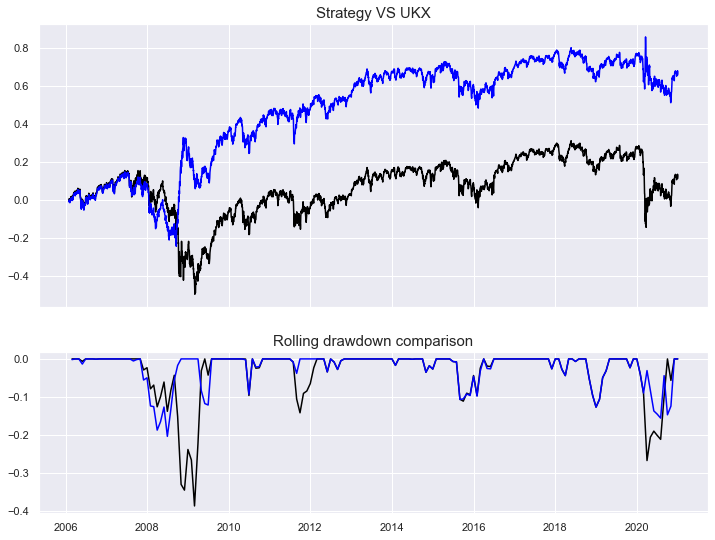

In [35]:
dataUKX = garch_UKX[["Ret_UKX", "Ret_INDEX"]].resample("M").sum()
dataUKX.rename(columns={"Ret_INDEX": "Ret_GARCH_INDEX"}, inplace=True)

# Rolling drawdown of the GRACH strategy
drd = drawdown(dataUKX)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(garch_UKX["Ret_UKX"].cumsum(), "black")
ax[0].plot(garch_UKX["Ret_INDEX"].cumsum(), "blue")
ax[0].set_title("Strategy VS UKX", fontsize=15)
ax[1].plot(drd["Ret_UKX"], "black")
ax[1].plot(drd["Ret_GARCH_INDEX"], "blue")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

In [36]:
# Try with SHCOMP
sh = equity_ret["SHCOMP"].loc["1995-01-01":]
garch_SHCOMP = create_index_garch(equity, "SHCOMP", sh, "1995-01-01", "2006-01-01", "SPVXSTR", 0.5, 0.75, 0.85, 0.95, 1)[0]

In [37]:
# Get the allocation weights
wsh, wfut = create_index_garch(equity, "SHCOMP", sh, "1995-01-01", "2006-01-01", "SPVXSTR", 0.5, 0.75, 0.85, 0.95, 1)[1:3]
wsh = np.array(wsh)
wfut = np.array(wfut)

weights_sh = pd.DataFrame({"SH_weights": wsh, "VIXFut_weights": wfut, "Tot": (wsh+wfut)}, index=garch_spxt.index)

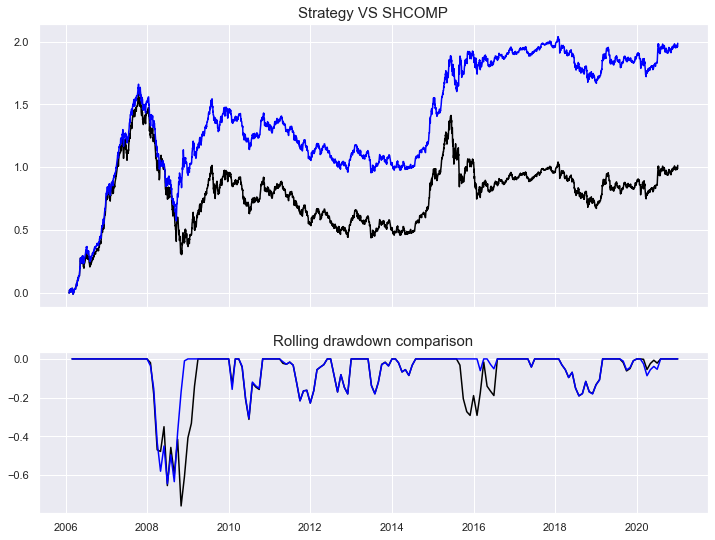

In [38]:
dataSHCOMP = garch_SHCOMP[["Ret_SHCOMP", "Ret_INDEX"]].resample("M").sum()
dataSHCOMP.rename(columns={"Ret_INDEX": "Ret_GARCH_INDEX"}, inplace=True)

# Rolling drawdown of the GRACH strategy
drd = drawdown(dataSHCOMP)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(garch_SHCOMP["Ret_SHCOMP"].cumsum(), "black")
ax[0].plot(garch_SHCOMP["Ret_INDEX"].cumsum(), "blue")
ax[0].set_title("Strategy VS SHCOMP", fontsize=15)
ax[1].plot(drd["Ret_SHCOMP"], "black")
ax[1].plot(drd["Ret_GARCH_INDEX"], "blue")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

### Example of "Bad weights" because of absence of good data for SHCOMP
In the next chart we can see how the GARCH signal is able to predict an increase in volatility associated with a strong downward trend in the SHCOMP index, but given that we are using VIX futures (which are based on the volatility of the S&P index) we don't see high positive returns because in those days the VIX index was not spiking, because the S&P was still experiencing decent returns and not big drops.

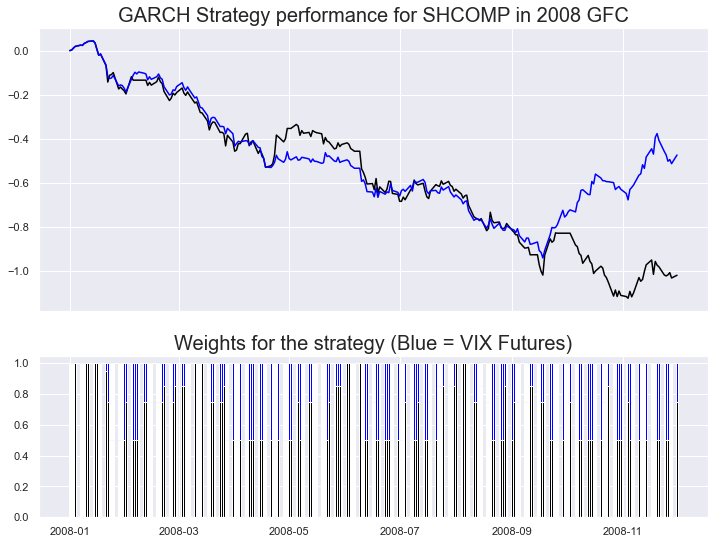

In [39]:
# SHCOMP bad weights example
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(garch_SHCOMP["Ret_SHCOMP"].loc["2008-01-01":"2008-12-01"].cumsum(), "black")
ax[0].plot(garch_SHCOMP["Ret_INDEX"].loc["2008-01-01":"2008-12-01"].cumsum(), "blue")
ax[0].set_title("GARCH Strategy performance for SHCOMP in 2008 GFC", fontsize=20)
ax[1].bar(x=weights_sh.loc["2008-01-01":"2008-12-01"].index, height=weights_sh["Tot"].loc["2008-01-01":"2008-12-01"], color="blue")
ax[1].bar(x=weights_sh.loc["2008-01-01":"2008-12-01"].index, height=weights_sh["SH_weights"].loc["2008-01-01":"2008-12-01"], color="black")
ax[1].set_title("Weights for the strategy (Blue = VIX Futures)", fontsize=20);

## Analysis for EUROSTOXX using:
 - Specific volatility index (VSTOXX)
 - Specific index tracking futures on VSTOXX (VST1MSL)

In [40]:
dataeuro = strategies_daily[["EUROSTOXX", "VSTOXX", "VST1MSL"]]
dataeuro = dataeuro.dropna()
dataeuro_ret = np.log(1+dataeuro.pct_change()).dropna()

In [41]:
# EUROSTOXX with GOOD data
garch_eurostoxx1 = strategies_daily_ret["EUROSTOXX"].loc["1995-01-01":]
garch_eurostoxx1 = create_index_garch(strategies_daily, "EUROSTOXX", garch_eurostoxx1, "1995-01-01", "2006-01-01", "VST1MSL", 0.5, 0.75, 0.85, 0.95, 1)[0]

In [42]:
# EUROSTOXX with BAD data
eurostoxx = strategies_daily_ret["EUROSTOXX"].loc["1995-01-01":]
garch_eurostoxx = create_index_garch(strategies_daily, "EUROSTOXX", eurostoxx, "1995-01-01", "2006-01-01", "SPVXSTR", 0.5, 0.75, 0.85, 0.95, 1)[0]

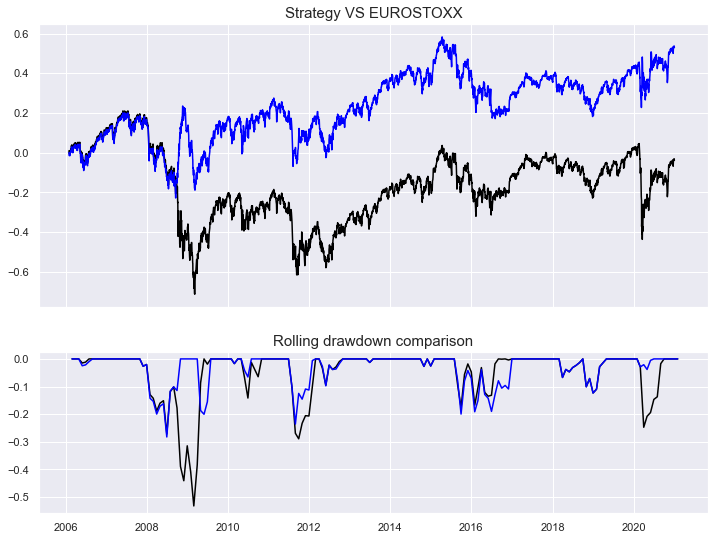

In [43]:
dataeurostoxx = garch_eurostoxx[["Ret_EUROSTOXX", "Ret_INDEX"]].resample("M").sum()
dataeurostoxx.rename(columns={"Ret_INDEX": "Ret_GARCH_INDEX"}, inplace=True)

# Rolling drawdown of the GARCH strategy
drd = drawdown(dataeurostoxx)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(garch_eurostoxx["Ret_EUROSTOXX"].cumsum(), "black")
ax[0].plot(garch_eurostoxx["Ret_INDEX"].cumsum(), "blue")
ax[0].set_title("Strategy VS EUROSTOXX", fontsize=15)
ax[1].plot(drd["Ret_EUROSTOXX"], "black")
ax[1].plot(drd["Ret_GARCH_INDEX"], "blue")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

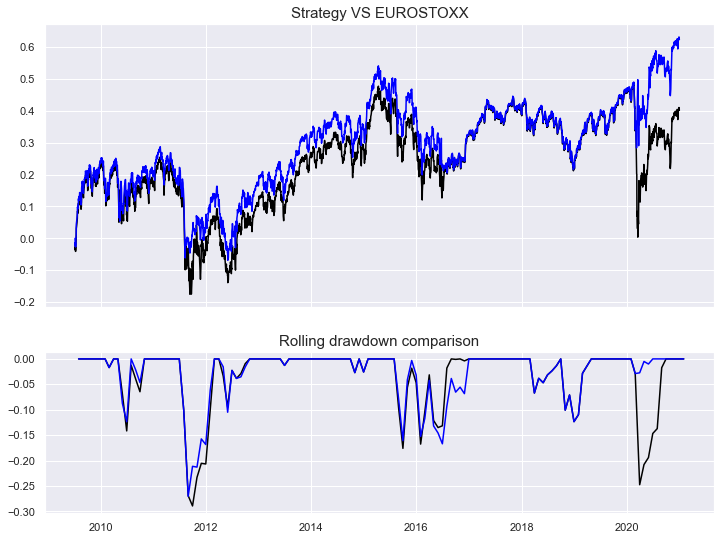

In [44]:
dataeurostoxx1 = garch_eurostoxx1[["Ret_EUROSTOXX", "Ret_INDEX"]].resample("M").sum()
dataeurostoxx1.rename(columns={"Ret_INDEX": "Ret_GARCH_INDEX"}, inplace=True)

# Rolling drawdown of the GARCH strategy
drd1 = drawdown(dataeurostoxx1)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(garch_eurostoxx1["Ret_EUROSTOXX"].cumsum(), "black")
ax[0].plot(garch_eurostoxx1["Ret_INDEX"].cumsum(), "blue")
ax[0].set_title("Strategy VS EUROSTOXX", fontsize=15)
ax[1].plot(drd1["Ret_EUROSTOXX"], "black")
ax[1].plot(drd1["Ret_GARCH_INDEX"], "blue")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

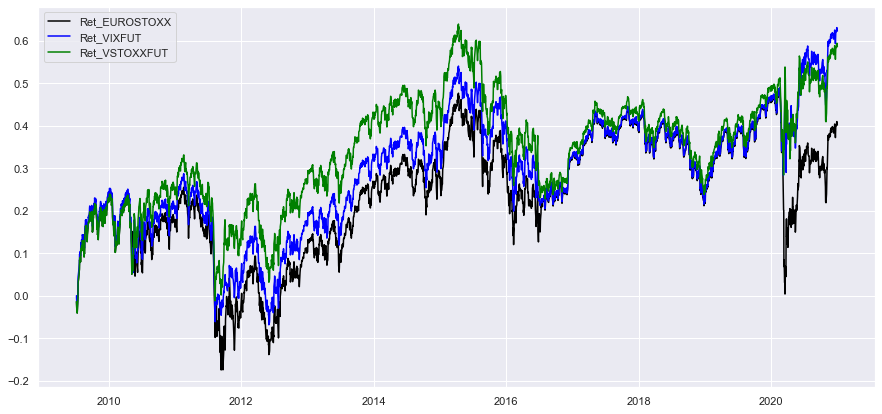

In [45]:
compare = garch_eurostoxx1[["Ret_EUROSTOXX", "Ret_INDEX"]].merge(garch_eurostoxx["Ret_INDEX"], on="Dates")
compare.rename(columns={"Ret_INDEX_x":"Ret_VIXFUT", "Ret_INDEX_y":"Ret_VSTOXXFUT"}, inplace=True)

plt.figure(figsize=(15, 7))
plt.plot(compare["Ret_EUROSTOXX"].cumsum(), "black")
plt.plot(compare["Ret_VIXFUT"].cumsum(), "blue")
plt.plot(compare["Ret_VSTOXXFUT"].cumsum(), "green")
plt.legend(compare.columns);

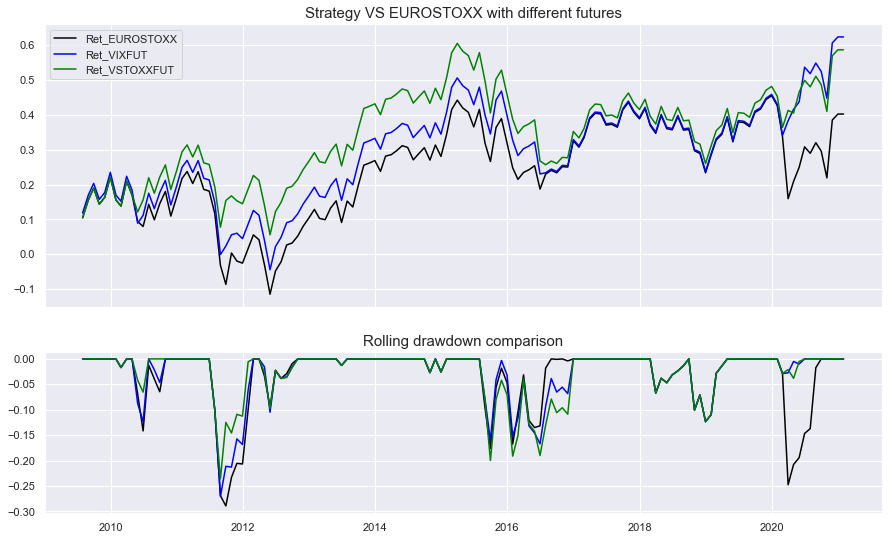

In [46]:
monthly = compare.resample("M").sum()

dd = drawdown(monthly)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(15, 9), sharex=True)
ax[0].plot(monthly["Ret_EUROSTOXX"].cumsum(), "black")
ax[0].plot(monthly["Ret_VIXFUT"].cumsum(), "blue")
ax[0].plot(monthly["Ret_VSTOXXFUT"].cumsum(), "green")
ax[0].set_title("Strategy VS EUROSTOXX with different futures", fontsize=15)
ax[0].legend(compare.columns)
ax[1].plot(dd["Ret_EUROSTOXX"], "black")
ax[1].plot(dd["Ret_VIXFUT"], "blue")
ax[1].plot(dd["Ret_VSTOXXFUT"], "green")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

In [47]:
# EUROSTOXX with GOOD data and CHANGING SIGNAL
garch_eurostoxxR = strategies_daily_ret["EUROSTOXX"].loc["1995-01-01":]
garch_eurostoxxR = create_index_garch(strategies_daily, "EUROSTOXX", garch_eurostoxxR, "1995-01-01", "2006-01-01", "VST1MSL", 0.5, 0.75, 0.85, 0.95, 1, basic=False, longer_period=False)[0]

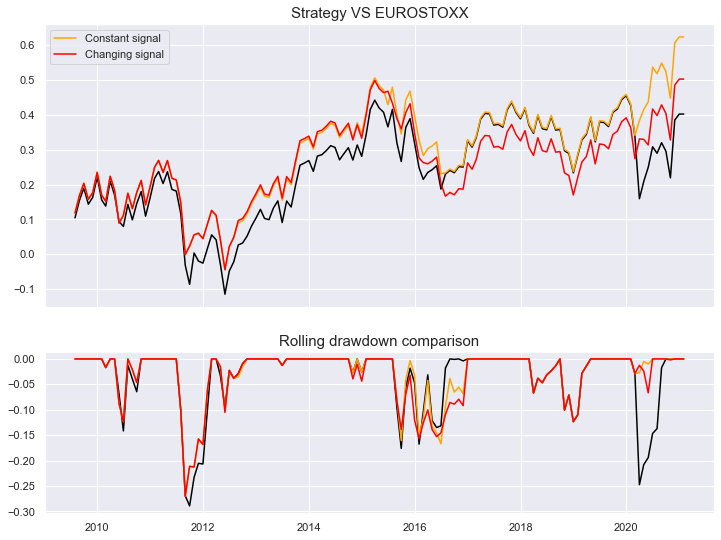

In [48]:
dataeurostoxxR = garch_eurostoxxR[["Ret_EUROSTOXX", "Ret_INDEX"]].resample("M").sum()
dataeurostoxxR.rename(columns={"Ret_INDEX": "Ret_GARCH_INDEX"}, inplace=True)

# Rolling drawdown of the GARCH strategy
drdR = drawdown(dataeurostoxxR)

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(dataeurostoxxR["Ret_EUROSTOXX"].cumsum(), "black")
ax[0].plot(dataeurostoxx1["Ret_GARCH_INDEX"].cumsum(), "orange", label="Constant signal")
ax[0].plot(dataeurostoxxR["Ret_GARCH_INDEX"].cumsum(), "red", label="Changing signal")
ax[0].set_title("Strategy VS EUROSTOXX", fontsize=15)
ax[0].legend()
ax[1].plot(drdR["Ret_EUROSTOXX"], "black")
ax[1].plot(drd1["Ret_GARCH_INDEX"], "orange")
ax[1].plot(drdR["Ret_GARCH_INDEX"], "red")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

# Tail Protection in the context of a diversified portfolio
Simple example with only equity indexes and equal weights and then more realisitc portfolio with gold, commodities index and bonds index added.

1) Equal weights portfolio

2) Portfolio optimized to maximize returns

3) Portfolio optimized to minimize ETL (Expected Tail Loss)

In [49]:
# Equal weights ONLY EQUITY
portfolio = mh.merge(dataUKX, on="Dates")
portfolio.rename(columns={"Ret_GARCH_INDEX_x": "INDEX_SP", "Ret_GARCH_INDEX_y": "INDEX_UKX"}, inplace=True)
portfolio = portfolio.merge(datadax, on="Dates")
portfolio.rename(columns={"Ret_GARCH_INDEX": "INDEX_DAX"}, inplace=True)
portfolio = portfolio.merge(dataNK, on="Dates")
portfolio.rename(columns={"Ret_GARCH_INDEX": "INDEX_NKY"}, inplace=True)
portfolio = portfolio.merge(dataSHCOMP, on="Dates")
portfolio.rename(columns={"Ret_GARCH_INDEX": "INDEX_SHCOMP"}, inplace=True)

In [50]:
portfolio["Basic"] = portfolio["Ret_SPXT"]*1/5 + portfolio["Ret_UKX"]*1/5 + portfolio["Ret_DAX"]*1/5 + portfolio["Ret_SHCOMP"]*1/5 + portfolio["Ret_NKY"]*1/5
portfolio["Insured"] = portfolio["INDEX_SP"]*1/5 + portfolio["INDEX_UKX"]*1/5 + portfolio["INDEX_DAX"]*1/5 + portfolio["INDEX_SHCOMP"]*1/5 + portfolio["INDEX_NKY"]*1/5

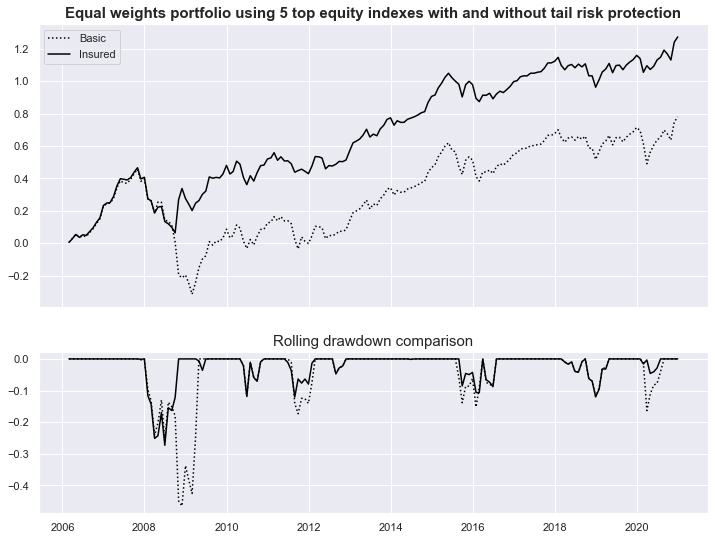

In [51]:
# Plot the results
drd = drawdown(portfolio[["Basic", "Insured"]])

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(portfolio["Basic"].cumsum(), "black", linestyle=":", label="Basic")
ax[0].plot(portfolio["Insured"].cumsum(), "black", label="Insured")
ax[0].set_title("Equal weights portfolio using 5 top equity indexes with and without tail risk protection", fontsize=15, fontweight="bold")
ax[0].legend()
ax[1].plot(drd["Basic"], "black", linestyle=":")
ax[1].plot(drd["Insured"], "black")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

### Global diversified portfolios

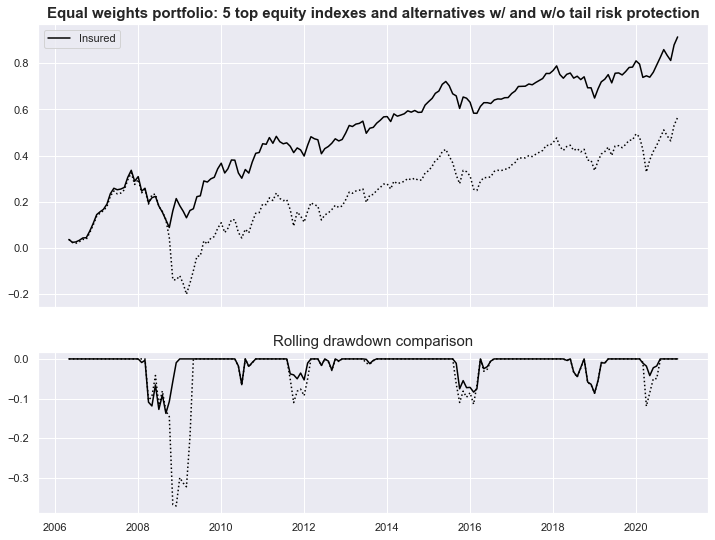

In [52]:
#import
opt_port = pd.read_csv("/Users/AlessioGiust/Desktop/TESI/optR.csv", index_col="Unnamed: 0")

# EQUAL WEIGHTS
eq_weig = [1/8]*8
port = opt_port[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 'SHCOMP', 'UKX', 'NKY']]
port.index = pd.to_datetime(port.index)
port = port.resample("M").sum()
pofo = port[3:]
pofo = pofo.merge(portfolio, left_index=True, right_index=True)
pofo.drop(columns=["Ret_SPXT", "Ret_UKX", "Ret_DAX", "Ret_NKY", "Ret_SHCOMP"], inplace=True)
pofo["Equal_Basic"] = (pofo[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 'SHCOMP', 'UKX', 'NKY']]*eq_weig).sum(axis=1)
pofo["Equal_Insured"] = (pofo[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*eq_weig).sum(axis=1)

# Plot the results
drd = drawdown(pofo[["Equal_Basic", "Equal_Insured"]])

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(pofo["Equal_Basic"].cumsum(), "black", linestyle=":")
ax[0].plot(pofo["Equal_Insured"].cumsum(), "black", label="Insured")
ax[0].set_title("Equal weights portfolio: 5 top equity indexes and alternatives w/ and w/o tail risk protection", fontsize=15, fontweight="bold")
ax[0].legend()
ax[1].plot(drd["Equal_Basic"], "black", linestyle=":")
ax[1].plot(drd["Equal_Insured"], "black")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

In [53]:
# MAX RETURNS and MIN EXPECTED TAIL LOSS portfolios (no rebalancing)
no_reb = pd.read_csv("/Users/AlessioGiust/Desktop/TESI/weights_norebR.csv", index_col="Unnamed: 0")
w_max_ret = no_reb["w1"].values
w_min_etl = no_reb["w2"].values

pofo["Max_ret"] = (pofo[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 'SHCOMP', 'UKX', 'NKY']]*w_max_ret).sum(axis=1)
pofo["Max_ret_insured"] =(pofo[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*w_max_ret).sum(axis=1)
pofo["Min_ETL"] = (pofo[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 'SHCOMP', 'UKX', 'NKY']]*w_min_etl).sum(axis=1)
pofo["Min_ETL_insured"] = (pofo[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*w_min_etl).sum(axis=1)

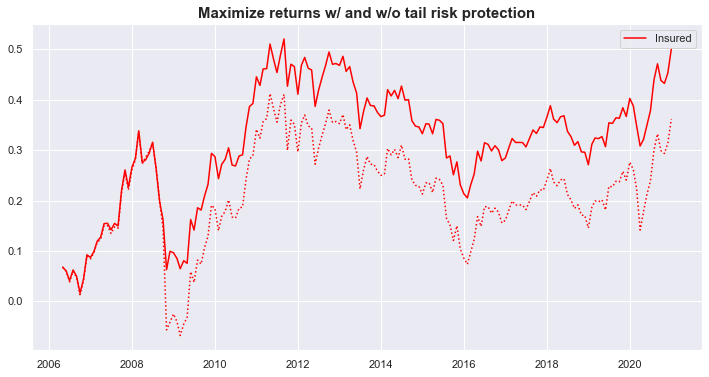

In [54]:
# MAX RETURNS
plt.figure(figsize=(12, 6))
plt.plot(pofo["Max_ret"].cumsum(), "red", linestyle=":")
plt.plot(pofo["Max_ret_insured"].cumsum(), "red", label="Insured")
plt.title("Maximize returns w/ and w/o tail risk protection", fontsize=15, fontweight="bold")
plt.legend();

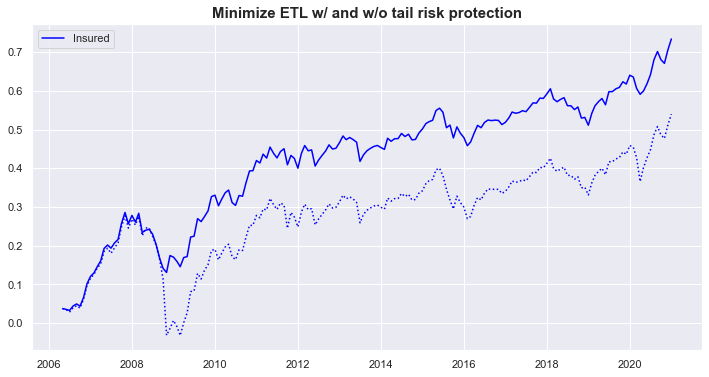

In [55]:
# MIN ETL
plt.figure(figsize=(12, 6))
plt.plot(pofo["Min_ETL"].cumsum(), "blue", linestyle=":")
plt.plot(pofo["Min_ETL_insured"].cumsum(), "blue", label="Insured")
plt.title("Minimize ETL w/ and w/o tail risk protection", fontsize=15, fontweight="bold")
plt.legend();

In [56]:
# REBALANCING annually w/ and w/o tail protection

############# MAX RETURNS #############
weig = pd.read_csv("/Users/AlessioGiust/Desktop/TESI/weightsR.csv", index_col="Unnamed: 0")
weig.rename(columns={"w1": "wr0"}, inplace=True)

# rebal1 for not insured, rebal2 for insured
rebal1 = pofo[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 'SHCOMP', 'UKX', 'NKY']]
rebal2 = pofo[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]
rebal1["Portfolio"] = np.zeros(len(rebal1))
rebal2["Portfolio"] = np.zeros(len(rebal2))

############# MIN ETL #############
etl_reb = pd.read_csv("/Users/AlessioGiust/Desktop/TESI/weights_etlrebR.csv", index_col="Unnamed: 0")
etl_reb.rename(columns={"w2": "wr0"}, inplace=True)

rebal1["PortfolioETL"] = np.zeros(len(rebal1))
rebal2["PortfolioETL"] = np.zeros(len(rebal2))

In [57]:
for i in range(14):
    if i < 13:
        ############# MAX RET
        rebal1["Portfolio"].loc[12*i:12*(i+1)] = (rebal1[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 
        'DAX', 'SHCOMP', 'UKX', 'NKY']]*weig[f"wr{i}"].values).sum(axis=1)
        # insured
        rebal2["Portfolio"].loc[12*i:12*(i+1)] = (rebal2[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 
        'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*weig[f"wr{i}"].values).sum(axis=1)
        ############# MIN ETL
        rebal1["PortfolioETL"].loc[12*i:(12*(i+1))] = (rebal1[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 
        'DAX', 'SHCOMP', 'UKX', 'NKY']]*etl_reb[f"wr{i}"].values).sum(axis=1)
        # insured 
        rebal2["PortfolioETL"].loc[12*i:(12*(i+1))] = (rebal2[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX',
        'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*etl_reb[f"wr{i}"].values).sum(axis=1)
    else:
        ############# MAX RET
        rebal1["Portfolio"].loc[12*i:] = (rebal1[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 
        'SHCOMP', 'UKX', 'NKY']]*weig[f"wr{i}"].values).sum(axis=1)
        # insured
        rebal2["Portfolio"].loc[12*i:] = (rebal2[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 
        'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*weig[f"wr{i}"].values).sum(axis=1)
        ############# MIN ETL
        rebal1["PortfolioETL"].loc[12*i:] = (rebal1[['LBUSTRUU', 'SPY', 'XAU', 'BCOM', 'DAX', 
        'SHCOMP', 'UKX', 'NKY']]*etl_reb[f"wr{i}"].values).sum(axis=1)
        # insured
        rebal2["PortfolioETL"].loc[12*i:] = (rebal2[['LBUSTRUU', 'INDEX_SP', 'XAU', 'BCOM', 'INDEX_DAX', 
        'INDEX_SHCOMP', 'INDEX_UKX', 'INDEX_NKY']]*etl_reb[f"wr{i}"].values).sum(axis=1)

/Users/AlessioGiust/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


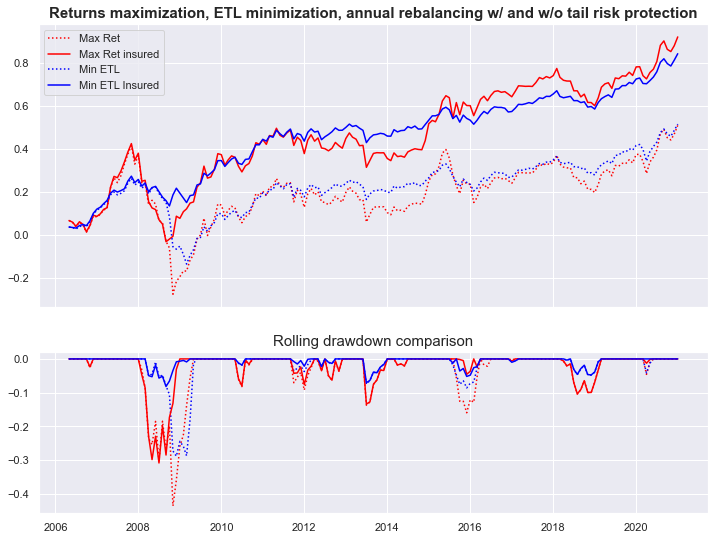

In [58]:
# Plot the results
drd1 = drawdown(rebal1[["Portfolio", "PortfolioETL"]])
drd2 = drawdown(rebal2[["Portfolio", "PortfolioETL"]])

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [7, 4]}, figsize=(12, 9), sharex=True)
ax[0].plot(rebal1["Portfolio"].cumsum(),  "red", linestyle=":", label = "Max Ret")
ax[0].plot(rebal2["Portfolio"].cumsum(), "red", label="Max Ret insured")
ax[0].plot(rebal1["PortfolioETL"].cumsum(), "blue", linestyle=":", label="Min ETL")
ax[0].plot(rebal2["PortfolioETL"].cumsum(), "blue", label="Min ETL Insured")
ax[0].set_title("Returns maximization, ETL minimization, annual rebalancing w/ and w/o tail risk protection", fontsize=15, fontweight="bold")
ax[0].legend()
ax[1].plot(drd1["Portfolio"], "red", linestyle=":")
ax[1].plot(drd1["PortfolioETL"], "blue", linestyle=":")
ax[1].plot(drd2["Portfolio"], "red")
ax[1].plot(drd2["PortfolioETL"], "blue")
ax[1].set_title("Rolling drawdown comparison", fontsize=15);

In [59]:
###### CHECK ALL METRICS ######
for_metrics = rebal1[["Portfolio", "PortfolioETL"]]
for_metrics.rename(columns={"Portfolio": "MaxRet", "PortfolioETL": "MinETL"}, inplace=True)
for_metrics = for_metrics.merge(rebal2[["Portfolio", "PortfolioETL"]], right_index=True, left_index=True)
for_metrics.rename(columns={"Portfolio": "MaxRet_INSURED", "PortfolioETL": "MinETL_INSURED"}, inplace=True)

traditional_metrics(for_metrics, equity, no_price=True).drop(columns="IR") #equity not used

/Users/AlessioGiust/Desktop/TESI/Codici Tesi/functions_thesis.py:26: RuntimeWarning: invalid value encountered in double_scalars
  IR.append((avg_ret_data[tick] - avg_ret_data[index_tick])/(qq["diff_sp_{}".format(tick)].std()))


CAGR  Monthly Return  Monthly Volatility    Sharpe  \
MaxRet          0.034530        0.002878            0.041259  0.069743   
MinETL          0.034927        0.002911            0.024481  0.118889   
MaxRet_INSURED  0.062353        0.005196            0.036335  0.143004   
MinETL_INSURED  0.057070        0.004756            0.019751  0.240790   

                 Sortino       VaR      CVaR  Max Drawdown  
MaxRet          0.081107  0.078260  0.108177     -0.435937  
MinETL          0.136724  0.035443  0.060772     -0.288417  
MaxRet_INSURED  0.191539  0.055857  0.086087     -0.308496  
MinETL_INSURED  0.383033  0.028375  0.038334     -0.081767